In [1]:
import os
import time
import math
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import transformers

from datetime import date
from transformers import BertModel,BertTokenizer,BertConfig,BertTokenizerFast
from sklearn.metrics import *
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F

from torch import Tensor
from torch.optim import *
from torch.nn.modules.loss import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader,Dataset

from nltk.tokenize import word_tokenize
import spacy

import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


from sklearn.metrics import confusion_matrix

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

D:\Anaconda\Lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
D:\Anaconda\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
import pandas as pd


df=pd.read_csv(r"D:\华科学习\毕业设计\data\train.csv\train.csv")

In [17]:
df=pd.read_csv(r'c:\Users\Hero Stephen\Desktop\咸鱼\label_data.csv')

***exploration***

In [3]:
df['tweets'].apply(lambda x:len(word_tokenize(x))).sort_values(ascending=False)

48269    73
56240    67
17755    57
4723     49
68771    49
         ..
28512     2
63043     2
31250     2
34849     2
26091     2
Name: tweets, Length: 81408, dtype: int64

In [4]:
nlp=spacy.load('en_core_web_sm')

pos_ls=[]

for text in df[df['class']=='irony']['tweets']:
    doc=nlp(text)
    for token in doc:
        pos_ls.append(token.pos_)



D:\Anaconda\Lib\site-packages\spacy\util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.0.0) was trained with spaCy v3.0.0 and may not be 100% compatible with the current version (3.7.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


KeyboardInterrupt: 

In [9]:
from collections import Counter

dict(Counter(pos_ls))

{'ADJ': 25471,
 'NOUN': 100339,
 'ADP': 30719,
 'PROPN': 36479,
 'PUNCT': 41036,
 'NUM': 15865,
 'PRON': 28386,
 'VERB': 49739,
 'PART': 10394,
 'ADV': 18857,
 'DET': 26172,
 'SCONJ': 4092,
 'AUX': 16649,
 'CCONJ': 7511,
 'SYM': 9719,
 'INTJ': 2372,
 'SPACE': 5690,
 'X': 2920}

In [10]:
import matplotlib.pyplot as plt
import plotly.express as px



pos_count=pd.DataFrame(list(dict(Counter(pos_ls)).items()),columns=['POS','Count'])


# 画饼图
fig = px.pie(
    pos_count, names='POS', values='Count', 
    title='Part-of-Speech Distribution in Ironic Comments'
)

# 紧凑布局设置
fig.update_layout(
    title={'x': 0.5, 'xanchor': 'center'},  # 标题居中
    margin=dict(t=40, b=10, l=10, r=10),    # 紧缩边距
    legend=dict(
        x=0.85, y=0.5,
        xanchor='left',
        orientation='v',
        font=dict(size=10)
    )
)

fig.show()





In [26]:
df['Sentiment'] = df['Sentiment'].apply(lambda x: x.lower() if type(x)==str else 0)



In [28]:
df=df[~df['Sentiment'].isin([0,'0'])]

In [34]:
from sklearn.preprocessing import LabelEncoder

df['Sentiment']=LabelEncoder().fit_transform(df[['Sentiment']])

D:\Anaconda\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [84]:
class PytorchDataset(Dataset):

    def __init__(self,df):
        super().__init__()
        self.df=df
        self.word_ids=np.array([word_ids for word_ids in df['input_word_ids']]).astype(int)
        self.attention_weights=np.array([attention for attention in df['attention_mask']]).astype(int)
        self.token_inputs=np.array([token for token in df['token_type_ids']]).astype(int)

        try:
            self.y=df['Sentiment'].values
        except:
            self.y=np.zeros(len(df))


    def __len__(self):
        return len(self.df)

    def __getitem__(self,i):
        return torch.tensor(self.word_ids[i],dtype=torch.long),torch.tensor(self.attention_weights[i],dtype=torch.long),torch.tensor(self.token_inputs[i],dtype=torch.long),torch.tensor(self.y[i],dtype=torch.long)




In [38]:
import nltk

#数据清洗的过程
def clean_text_simple(text):
    stopwords=nltk.corpus.stopwords.words('english')
    if not isinstance(text, str):
        return ""

    # 只保留 字母、数字、空格、基本标点（.,!?）
    cleaned = re.sub(r'[^\w\s.,!?]', ' ', text)
    cleaned = re.sub(r'\s+', ' ', cleaned)

    # 剔除超长乱码（假设>15个连续字母/数字是乱码）
    cleaned = ' '.join(
        word for word in cleaned.split()
        if len(word) <= 15 and re.match(r'^[a-zA-Z0-9.,!?]+$', word) and word not in stopwords
    )

    return cleaned.strip()


df['Description']=df['Description'].apply(lambda x:clean_text_simple(x))

**数据的降采样**

In [10]:

stop_words=stopwords.words('english')
stemmer=WordNetLemmatizer()

def text_preprocessing(text):
    text=re.sub(r'[^\S\n]', ' ', text) #清除连续的空白
    text=re.sub(r"[^\w\s]", "", text)
    text=re.sub(r'[0-9]','',text)
    text=re.sub(r"https?://[^\s]+",'',text)  #清除网站
    #清除标点符号
    translator=str.maketrans('','',string.punctuation+"@#$%^&*()_+!(){}[]|\/<>~`")
    text=text.translate(translator)
    text=word_tokenize(text)
    text=[word for word in text if word not in stop_words]
    text=[stemmer.lemmatize(word) for word in text]
    text=' '.join([word for word in text])

    return text








In [13]:
# from collections import Counter


# # global pos_tags
# # pos_tags=[]



# # def pos_count(text):
# #     doc=nlp(text)
    
# #     for i in doc:
# #         pos_tags.append(i.pos_)



# # #需要进行剔除  空格，符号，数字等
# # dict(Counter(pos_tags))



# #计算长度
# df['text len']=df['headline'].apply(lambda x:len(x.split()))




# #降采样

# df_sarcasm=df[df['is_sarcastic']==1]
# df_no_sarcasm=df[df['is_sarcastic']==0]

# sarcasm_len_ratio=df_sarcasm['text len'].value_counts(normalize=True).sort_index()
# df_no_sarcasm_len_ratio=df_no_sarcasm['text len'].value_counts(normalize=True).sort_index()

# def under_sample(df,ratio,target_size):
#     weights=df['text len'].map(ratio)
#     sampled_data=df.sample(n=target_size,weights=weights,random_state=42)

#     return sampled_data


# sarcasm_data=under_sample(df_sarcasm,sarcasm_len_ratio,12000)
# unsarcasm_data=under_sample(df_no_sarcasm,df_no_sarcasm_len_ratio,120000)


# df_sampled=pd.concat(
#     [sarcasm_data,unsarcasm_data],axis=0

# )





In [11]:
df['clean_text']=df['tweets'].apply(lambda x:text_preprocessing(x))

In [12]:
df=df.reset_index(drop=True)

In [ ]:
# from transformers import AutoModelForSequenceClassification
# from transformers import AutoTokenizer



# # tokenizer = AutoTokenizer.from_pretrained('english-sarcasm-detector')
# # model = AutoModelForSequenceClassification.from_pretrained('english-sarcasm-detector')
# # MODEL_PATH = r"D:\vscode\sarcasm model"

# # tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
# # bert_model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased')

# bert_config=BertConfig.from_json_file(r"D:\vscode\bert sarcasm\config.json")
# bert_model=BertModel(bert_config)

# tokenizer=BertTokenizer.from_pretrained(r"jkhan447/sarcasm-detection-Bert-base-uncased")

In [70]:
from transformers import TFAutoModel



bert_model = TFAutoModel.from_pretrained('bert-base-uncased')




Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [41]:



encoded_inputs = tokenizer.batch_encode_plus(
    df['Description'].tolist(), 
    padding=True, 
    truncation=True, 
    return_tensors='pt'
)
# df_sampled['input_word_ids'] = encoded_inputs['input_ids']
# df_sampled['attention_mask'] = encoded_inputs['attention_mask']
# df_sampled['token_type_ids'] = encoded_inputs['token_type_ids']

In [42]:
df['input_word_ids']=encoded_inputs['input_ids'].tolist()

In [43]:
df['attention_mask'] = encoded_inputs['attention_mask'].tolist()
df['token_type_ids'] = encoded_inputs['token_type_ids'].tolist()

In [58]:
from pytorchtools import EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score

def fit(model, train_dataset, val_dataset, batch_size, warmup_prop=0, lr=0.00005, epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    num_warmup_steps = int(warmup_prop * epochs * len(train_loader))
    num_training_steps = epochs * len(train_loader)  
    schedular = transformers.get_linear_schedule_with_warmup(optimizer, 10, num_training_steps)
    early_stopping=EarlyStopping(patience=5)
    loss_fct = nn.CrossEntropyLoss().to(device)
   

    for epoch in range(epochs):
        model.train()
        start_time = time.time()
        avg_loss = 0
        train_correct = 0

        for step, (x, x_attention, token, y_batch) in tqdm(enumerate(train_loader), total=len(train_loader)):
            x, x_attention, token, y_batch = x.to(device), x_attention.to(device), token.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(x, token, x_attention)
            loss = loss_fct(y_pred, y_batch)
            loss.backward()

            optimizer.step()
            schedular.step()
            optimizer.zero_grad(set_to_none=True)  # 释放显存

            pred = y_pred.argmax(dim=1, keepdim=True)
            train_correct += pred.eq(y_batch.view_as(pred)).sum().item()
            lr=schedular.get_lr()[0]
            
            avg_loss += loss.item() / len(train_loader)
            torch.cuda.empty_cache()  # 强制清理显存

        schedular.step()

        model.eval()
        avg_val_loss = 0
        test_correct = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for x, x_attention, token, y_batch in val_loader:
                x, x_attention, token, y_batch = x.to(device), x_attention.to(device), token.to(device), y_batch.to(device)
                y_pred = model(x, token, x_attention)

                loss = loss_fct(y_pred, y_batch)
                avg_val_loss += loss.item() / len(val_loader)

                preds = y_pred.argmax(dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(y_batch.cpu().numpy())

                test_correct += preds.eq(y_batch).sum().item()

        val_auc = test_correct / len(val_loader.dataset)
        precision = precision_score(all_labels, all_preds, average='macro')
        recall = recall_score(all_labels, all_preds, average='macro')
        f1 = f1_score(all_labels, all_preds, average='macro')

        early_stopping(val_auc, model)

        if early_stopping.early_stop:
            print('Early Stopping')
            break

        print(f'Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f} - Val Loss: {avg_val_loss:.4f} '
              f'- Train Acc: {train_correct/len(train_loader.dataset):.4f} - Val Acc: {val_auc:.4f} '
              f'- Precision: {precision:.4f} - Recall: {recall:.4f} - F1: {f1:.4f} - lr: {lr:.6f}')


In [53]:
class BIGRU_CNN(nn.Module):
    def __init__(self,bert_model,num_classes, vocab_size,embedded_dim,hidden_size, kernel_sizes=[4,5,6], num_channels=[128,128,128]):
        super(BIGRU_CNN, self).__init__()
        self.bert_model=bert_model
        self.vocab_size=vocab_size
        self.embedded_dim=embedded_dim
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.embedding=nn.Embedding(self.vocab_size,self.embedded_dim)

        self.BIGRU1 = nn.GRU(input_size=self.embedded_dim, hidden_size=self.hidden_size[0], num_layers=2, bidirectional=True, batch_first=True)
        # self.BIGRU2 = nn.GRU(input_size=self.hidden_size[0] * 2, hidden_size=self.hidden_size[1], num_layers=1, bidirectional=True, batch_first=False)

        # 卷积层
        self.cnn_layers = nn.ModuleList()  # 创建多个一维卷积层
        for c, k in zip(num_channels, kernel_sizes):
            cnn = nn.Sequential(
                nn.Conv1d(in_channels=self.hidden_size[0]*2, out_channels=c, kernel_size=k),
                nn.BatchNorm1d(c),
                nn.ReLU(),
                nn.Dropout(0.5)
            )
            # cnn=nn.Sequential(
            #         # 改成2维度，输入通道就是1了，输出通道人定，而卷积核宽度一旦和词嵌入矩阵的宽度一直，那么卷积核只会上下滑动，因此等价于一维卷积，串联的时候也一样
            #         nn.Conv2d(in_channels=1, out_channels=c, kernel_size=(k,self.hidden_size[-1])), nn.BatchNorm2d(c),
            #         nn.Sigmoid(), nn.Dropout(0.5),
            #     )
            self.cnn_layers.append(cnn)
        self.pool = nn.AdaptiveMaxPool1d(1) #按照max len来张开

        # 输出层
        self.fc = nn.Sequential(
            nn.Dropout(p=0.5),  #防止过拟合
            nn.Linear(sum(num_channels), num_classes),  # 使用 nn.Linear
            nn.ReLU(),  # 使用 nn.ReLU 作为激活函数
            nn.Softmax(dim=1)
        )

    def forward(self, input_ids,tokens,attention_mask):
        
        
        
        # last_hidden_states=self.bert_model(input_ids,attention_mask=attention_mask,token_type_ids=tokens).last_hidden_state
        embedded_inputs=self.embedding(input_ids)
        
        
        
        # 传入 BIGRU 计算输出
        outputs, _ = self.BIGRU1(embedded_inputs)
        # outputs, _ = self.BIGRU2(outputs)

        # CNN 处理
        y = []
        cnn_input = outputs.permute(0, 2, 1)  # (batch_size, hidden_dim, seq_len)

        # 遍历各个卷积层
        for layer in self.cnn_layers:
            x = layer(cnn_input)
            x = self.pool(x)
            x = x.view(x.size(0), x.size(1), -1)
            y.append(x)

        # 将所有卷积层输出的结果拼接在一起
        y = torch.cat(y, dim=1)
        y = y.view(y.size(0), -1)
        
        # 通过全连接层得到最终输出
        out = self.fc(y)
        return out


In [71]:
from sklearn.model_selection import train_test_split



df_train,df_test=train_test_split(df,shuffle=True,test_size=0.1,random_state=42,stratify=df['Sentiment'])
df_train,df_val=train_test_split(df_train,shuffle=True,random_state=42,test_size=0.1,stratify=df_train['Sentiment'])


In [85]:
train_dataset=PytorchDataset(df_train)
val_dataset=PytorchDataset(df_val)
test_dataset=PytorchDataset(df_test)


In [86]:

model=BIGRU_CNN(bert_model,vocab_size=50000,embedded_dim=64,num_classes=3,hidden_size=[64,64])

In [87]:


fit(model,train_dataset,val_dataset,batch_size=64)

  0%|          | 0/171 [00:00<?, ?it/s]

D:\Anaconda\Lib\site-packages\torch\optim\lr_scheduler.py:271: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch 1/5 - Loss: 0.8357 - Val Loss: 0.8232 - Train Acc: 0.7210 - Val Acc: 0.7283 - Precision: 0.2428 - Recall: 0.3333 - F1: 0.2809 - lr: 0.000040


D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  0%|          | 0/171 [00:00<?, ?it/s]

D:\Anaconda\Lib\site-packages\torch\optim\lr_scheduler.py:271: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch 2/5 - Loss: 0.8233 - Val Loss: 0.8232 - Train Acc: 0.7284 - Val Acc: 0.7283 - Precision: 0.2428 - Recall: 0.3333 - F1: 0.2809 - lr: 0.000030


D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  0%|          | 0/171 [00:00<?, ?it/s]

D:\Anaconda\Lib\site-packages\torch\optim\lr_scheduler.py:271: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch 3/5 - Loss: 0.8224 - Val Loss: 0.8232 - Train Acc: 0.7284 - Val Acc: 0.7283 - Precision: 0.2428 - Recall: 0.3333 - F1: 0.2809 - lr: 0.000020


D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  0%|          | 0/171 [00:00<?, ?it/s]

D:\Anaconda\Lib\site-packages\torch\optim\lr_scheduler.py:271: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch 4/5 - Loss: 0.8233 - Val Loss: 0.8232 - Train Acc: 0.7284 - Val Acc: 0.7283 - Precision: 0.2428 - Recall: 0.3333 - F1: 0.2809 - lr: 0.000010


D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  0%|          | 0/171 [00:00<?, ?it/s]

D:\Anaconda\Lib\site-packages\torch\optim\lr_scheduler.py:271: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch 5/5 - Loss: 0.8229 - Val Loss: 0.8232 - Train Acc: 0.7284 - Val Acc: 0.7283 - Precision: 0.2428 - Recall: 0.3333 - F1: 0.2809 - lr: 0.000000


D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [94]:
preds_bigru_cnn=[]


labels=[]
test_correct=0
device=torch.device('cuda')
test_loader=DataLoader(test_dataset,batch_size=64,shuffle=False)


for x, x_attention, token, y_batch in test_loader:
        x, x_attention, token, y_batch = x.to(device), x_attention.to(device), token.to(device), y_batch.to(device)
        y_pred = model(x, token, x_attention)

        preds = y_pred.argmax(dim=1)
        preds_bigru_cnn.extend(preds.cpu().numpy())
        labels.extend(y_batch.cpu().numpy())

        test_correct += preds.eq(y_batch).sum().item()

val_auc = test_correct / len(test_loader.dataset)
precision = precision_score(labels, preds_bigru_cnn, average='macro')
recall = recall_score(labels, preds_bigru_cnn, average='macro')
f1 = f1_score(labels, preds_bigru_cnn, average='macro')



print(
        f'ACC: {val_acc:.4f} - Precision: {precision:.4f} - Recall: {recall:.4f} - F1: {f1:.4f}')

ACC: 0.7281 - Precision: 0.2427 - Recall: 0.3333 - F1: 0.2809


D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**BIGUR**

In [26]:
class BILSTM(nn.Module):
    def __init__(self,bert_model,num_classes, vocab_size,embedded_dim,hidden_size, kernel_sizes=[4,5,6], num_channels=[128,128,128]):
        super(BILSTM, self).__init__()
        self.bert_model=bert_model
        self.vocab_size=vocab_size
        self.embedded_dim=embedded_dim
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.embedding=nn.Embedding(self.vocab_size,self.embedded_dim)

        self.BIGRU1 = nn.LSTM(input_size=self.embedded_dim, hidden_size=self.hidden_size[0], num_layers=2, bidirectional=True, batch_first=True)
        # self.BIGRU2 = nn.GRU(input_size=self.hidden_size[0] * 2, hidden_size=self.hidden_size[1], num_layers=1, bidirectional=True, batch_first=False)

        self.fc = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(self.hidden_size[0]*2, num_classes),  # 使用 nn.Linear
            nn.ReLU(),  # 使用 nn.ReLU 作为激活函数
            nn.Softmax(dim=1)
        )

    def forward(self, input_ids,tokens,attention_mask):
        
        
        
        # last_hidden_states=self.bert_model(input_ids,attention_mask=attention_mask,token_type_ids=tokens).last_hidden_state
        embedded_inputs=self.embedding(input_ids)
        
        
        
        # 传入 BIGRU 计算输出
        outputs, _ = self.BIGRU1(embedded_inputs)
        # outputs, _ = self.BIGRU2(outputs)

        y = outputs[:, -1, :] 
        # 通过全连接层得到最终输出
        out = self.fc(y)
        return out


In [27]:
class BIGRU(nn.Module):
    def __init__(self,bert_model,num_classes, vocab_size,embedded_dim,hidden_size, kernel_sizes=[4,5,6], num_channels=[128,128,128]):
        super(BIGRU, self).__init__()
        self.bert_model=bert_model
        self.vocab_size=vocab_size
        self.embedded_dim=embedded_dim
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.embedding=nn.Embedding(self.vocab_size,self.embedded_dim)

        self.BIGRU1 = nn.GRU(input_size=self.embedded_dim, hidden_size=self.hidden_size[0], num_layers=2, bidirectional=True, batch_first=True)
        # self.BIGRU2 = nn.GRU(input_size=self.hidden_size[0] * 2, hidden_size=self.hidden_size[1], num_layers=1, bidirectional=True, batch_first=False)

        self.fc = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(self.hidden_size[0]*2, num_classes),  # 使用 nn.Linear
            nn.ReLU(),  # 使用 nn.ReLU 作为激活函数
            nn.Softmax(dim=1)
        )

    def forward(self, input_ids,tokens,attention_mask):
        
        
        
        # last_hidden_states=self.bert_model(input_ids,attention_mask=attention_mask,token_type_ids=tokens).last_hidden_state
        embedded_inputs=self.embedding(input_ids)
        
        
        
        # 传入 BIGRU 计算输出
        outputs, _ = self.BIGRU1(embedded_inputs)
        # outputs, _ = self.BIGRU2(outputs)

        y = outputs[:, -1, :] 
        # 通过全连接层得到最终输出
        out = self.fc(y)
        return out


In [28]:
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self, bert_model, num_classes, vocab_size, embedded_dim, kernel_sizes=[4,5,6], num_channels=[128,128,128]):
        super(CNN, self).__init__()
        self.bert_model = bert_model
        self.vocab_size = vocab_size
        self.embedded_dim = embedded_dim
        self.num_classes = num_classes
        self.embedding = nn.Embedding(self.vocab_size, self.embedded_dim)
        
        # 卷积层
        self.cnn_layers = nn.ModuleList()  # 创建多个一维卷积层
        for c, k in zip(num_channels, kernel_sizes):
            cnn = nn.Sequential(
                nn.Conv1d(in_channels=self.embedded_dim, out_channels=c, kernel_size=k),  # 输入通道是词嵌入的维度
                nn.BatchNorm1d(c),
                nn.ReLU(),
                nn.Dropout(0.5)
            )
            self.cnn_layers.append(cnn)

        # 全局池化层
        self.pool = nn.AdaptiveMaxPool1d(1)  # 按照 max len 来张开
        
        # 输出层
        self.fc = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(sum(num_channels), num_classes),  # 使用 nn.Linear
            nn.ReLU(),  # 使用 nn.ReLU 作为激活函数
            nn.Softmax(dim=1)
        )

    def forward(self, input_ids, tokens, attention_mask):
        
        
        # 使用词嵌入作为输入 (如果不使用预训练模型嵌入，可以替换为嵌入层输出)
        embedded_inputs = self.embedding(input_ids)
        
        # CNN 处理
        y = []
        cnn_input = embedded_inputs.permute(0, 2, 1)  # 转置维度为 (batch_size, hidden_dim, seq_len)

        # 遍历各个卷积层
        for layer in self.cnn_layers:
            x = layer(cnn_input)
            x = self.pool(x)  # 池化层
            x = x.view(x.size(0), x.size(1), -1)  # 展平
            y.append(x)

        # 将所有卷积层输出的结果拼接在一起
        y = torch.cat(y, dim=1)
        y = y.view(y.size(0), -1)  # 展平

        # 通过全连接层得到最终输出
        out = self.fc(y)
        return out


In [29]:
bilstm=BILSTM(bert_model,vocab_size=50000,embedded_dim=64,num_classes=3,hidden_size=[64,64])

In [30]:
bigru=BIGRU(bert_model,vocab_size=50000,embedded_dim=64,num_classes=3,hidden_size=[64,64])

In [31]:
cnn=CNN(bert_model,vocab_size=50000,embedded_dim=64,num_classes=3)

In [32]:
fit(bilstm,train_dataset,val_dataset,batch_size=64)

  0%|          | 0/762 [00:00<?, ?it/s]

C:\Users\Hero Stephen\AppData\Local\Temp\ipykernel_20400\3088427532.py:20: DeprecationWarning:

an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.

D:\Anaconda\Lib\site-packages\torch\optim\lr_scheduler.py:271: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.

D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 1/50 - Loss: 1.0983 - Val Loss: 1.0982 - Train Acc: 0.3460 - Val Acc: 0.3473 - Precision: 0.1158 - Recall: 0.3333 - F1: 0.1719 - lr: 0.000049


  0%|          | 0/762 [00:00<?, ?it/s]

C:\Users\Hero Stephen\AppData\Local\Temp\ipykernel_20400\3088427532.py:20: DeprecationWarning:

an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.

D:\Anaconda\Lib\site-packages\torch\optim\lr_scheduler.py:271: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.

D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 2/50 - Loss: 1.0983 - Val Loss: 1.0982 - Train Acc: 0.3473 - Val Acc: 0.3473 - Precision: 0.1158 - Recall: 0.3333 - F1: 0.1719 - lr: 0.000048


  0%|          | 0/762 [00:00<?, ?it/s]

C:\Users\Hero Stephen\AppData\Local\Temp\ipykernel_20400\3088427532.py:20: DeprecationWarning:

an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.

D:\Anaconda\Lib\site-packages\torch\optim\lr_scheduler.py:271: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.

D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 3/50 - Loss: 1.0983 - Val Loss: 1.0982 - Train Acc: 0.3473 - Val Acc: 0.3473 - Precision: 0.1158 - Recall: 0.3333 - F1: 0.1719 - lr: 0.000047


  0%|          | 0/762 [00:00<?, ?it/s]

C:\Users\Hero Stephen\AppData\Local\Temp\ipykernel_20400\3088427532.py:20: DeprecationWarning:

an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.

D:\Anaconda\Lib\site-packages\torch\optim\lr_scheduler.py:271: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.

D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 4/50 - Loss: 1.0983 - Val Loss: 1.0982 - Train Acc: 0.3473 - Val Acc: 0.3473 - Precision: 0.1158 - Recall: 0.3333 - F1: 0.1719 - lr: 0.000046


  0%|          | 0/762 [00:00<?, ?it/s]

C:\Users\Hero Stephen\AppData\Local\Temp\ipykernel_20400\3088427532.py:20: DeprecationWarning:

an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.

D:\Anaconda\Lib\site-packages\torch\optim\lr_scheduler.py:271: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.

D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 5/50 - Loss: 1.0982 - Val Loss: 1.0982 - Train Acc: 0.3473 - Val Acc: 0.3473 - Precision: 0.1158 - Recall: 0.3333 - F1: 0.1719 - lr: 0.000045


  0%|          | 0/762 [00:00<?, ?it/s]

C:\Users\Hero Stephen\AppData\Local\Temp\ipykernel_20400\3088427532.py:20: DeprecationWarning:

an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.

D:\Anaconda\Lib\site-packages\torch\optim\lr_scheduler.py:271: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.

D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 6/50 - Loss: 1.0982 - Val Loss: 1.0982 - Train Acc: 0.3473 - Val Acc: 0.3473 - Precision: 0.1158 - Recall: 0.3333 - F1: 0.1719 - lr: 0.000044


  0%|          | 0/762 [00:00<?, ?it/s]

C:\Users\Hero Stephen\AppData\Local\Temp\ipykernel_20400\3088427532.py:20: DeprecationWarning:

an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.

D:\Anaconda\Lib\site-packages\torch\optim\lr_scheduler.py:271: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.

D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 7/50 - Loss: 1.0981 - Val Loss: 1.0976 - Train Acc: 0.3459 - Val Acc: 0.3473 - Precision: 0.1158 - Recall: 0.3333 - F1: 0.1719 - lr: 0.000043


  0%|          | 0/762 [00:00<?, ?it/s]

C:\Users\Hero Stephen\AppData\Local\Temp\ipykernel_20400\3088427532.py:20: DeprecationWarning:

an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.

D:\Anaconda\Lib\site-packages\torch\optim\lr_scheduler.py:271: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.

D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 8/50 - Loss: 1.0975 - Val Loss: 1.0973 - Train Acc: 0.3483 - Val Acc: 0.3473 - Precision: 0.1158 - Recall: 0.3333 - F1: 0.1719 - lr: 0.000042


  0%|          | 0/762 [00:00<?, ?it/s]

C:\Users\Hero Stephen\AppData\Local\Temp\ipykernel_20400\3088427532.py:20: DeprecationWarning:

an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.

D:\Anaconda\Lib\site-packages\torch\optim\lr_scheduler.py:271: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



Epoch 9/50 - Loss: 1.0972 - Val Loss: 1.0941 - Train Acc: 0.3455 - Val Acc: 0.3920 - Precision: 0.2854 - Recall: 0.3781 - F1: 0.3162 - lr: 0.000041


D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



  0%|          | 0/762 [00:00<?, ?it/s]

C:\Users\Hero Stephen\AppData\Local\Temp\ipykernel_20400\3088427532.py:20: DeprecationWarning:

an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.

D:\Anaconda\Lib\site-packages\torch\optim\lr_scheduler.py:271: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



Epoch 10/50 - Loss: 1.0069 - Val Loss: 0.9759 - Train Acc: 0.5099 - Val Acc: 0.5445 - Precision: 0.4654 - Recall: 0.5247 - F1: 0.4441 - lr: 0.000040


D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



  0%|          | 0/762 [00:00<?, ?it/s]

C:\Users\Hero Stephen\AppData\Local\Temp\ipykernel_20400\3088427532.py:20: DeprecationWarning:

an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.

D:\Anaconda\Lib\site-packages\torch\optim\lr_scheduler.py:271: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



Epoch 11/50 - Loss: 0.9613 - Val Loss: 0.9484 - Train Acc: 0.5433 - Val Acc: 0.5598 - Precision: 0.6400 - Recall: 0.5430 - F1: 0.5018 - lr: 0.000039


  0%|          | 0/762 [00:00<?, ?it/s]

C:\Users\Hero Stephen\AppData\Local\Temp\ipykernel_20400\3088427532.py:20: DeprecationWarning:

an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.

D:\Anaconda\Lib\site-packages\torch\optim\lr_scheduler.py:271: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



Epoch 12/50 - Loss: 0.8531 - Val Loss: 0.7445 - Train Acc: 0.7223 - Val Acc: 0.8360 - Precision: 0.8373 - Recall: 0.8360 - F1: 0.8356 - lr: 0.000038


  0%|          | 0/762 [00:00<?, ?it/s]

C:\Users\Hero Stephen\AppData\Local\Temp\ipykernel_20400\3088427532.py:20: DeprecationWarning:

an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.

D:\Anaconda\Lib\site-packages\torch\optim\lr_scheduler.py:271: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



Epoch 13/50 - Loss: 0.7261 - Val Loss: 0.6889 - Train Acc: 0.8499 - Val Acc: 0.8752 - Precision: 0.8749 - Recall: 0.8737 - F1: 0.8741 - lr: 0.000037


  0%|          | 0/762 [00:00<?, ?it/s]

C:\Users\Hero Stephen\AppData\Local\Temp\ipykernel_20400\3088427532.py:20: DeprecationWarning:

an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.

D:\Anaconda\Lib\site-packages\torch\optim\lr_scheduler.py:271: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



Epoch 14/50 - Loss: 0.6889 - Val Loss: 0.6735 - Train Acc: 0.8769 - Val Acc: 0.8839 - Precision: 0.8882 - Recall: 0.8813 - F1: 0.8827 - lr: 0.000036


  0%|          | 0/762 [00:00<?, ?it/s]

C:\Users\Hero Stephen\AppData\Local\Temp\ipykernel_20400\3088427532.py:20: DeprecationWarning:

an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.

D:\Anaconda\Lib\site-packages\torch\optim\lr_scheduler.py:271: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



Epoch 15/50 - Loss: 0.6718 - Val Loss: 0.6603 - Train Acc: 0.8884 - Val Acc: 0.8966 - Precision: 0.8997 - Recall: 0.8950 - F1: 0.8959 - lr: 0.000035


  0%|          | 0/762 [00:00<?, ?it/s]

C:\Users\Hero Stephen\AppData\Local\Temp\ipykernel_20400\3088427532.py:20: DeprecationWarning:

an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.

D:\Anaconda\Lib\site-packages\torch\optim\lr_scheduler.py:271: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



Epoch 16/50 - Loss: 0.6557 - Val Loss: 0.6534 - Train Acc: 0.9029 - Val Acc: 0.9007 - Precision: 0.9050 - Recall: 0.9010 - F1: 0.9005 - lr: 0.000034


  0%|          | 0/762 [00:00<?, ?it/s]

C:\Users\Hero Stephen\AppData\Local\Temp\ipykernel_20400\3088427532.py:20: DeprecationWarning:

an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.

D:\Anaconda\Lib\site-packages\torch\optim\lr_scheduler.py:271: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



Epoch 17/50 - Loss: 0.6473 - Val Loss: 0.6331 - Train Acc: 0.9087 - Val Acc: 0.9202 - Precision: 0.9207 - Recall: 0.9200 - F1: 0.9197 - lr: 0.000033


  0%|          | 0/762 [00:00<?, ?it/s]

C:\Users\Hero Stephen\AppData\Local\Temp\ipykernel_20400\3088427532.py:20: DeprecationWarning:

an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.

D:\Anaconda\Lib\site-packages\torch\optim\lr_scheduler.py:271: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



Early Stopping


In [33]:
fit(bigru,train_dataset,val_dataset,batch_size=64)

  0%|          | 0/762 [00:00<?, ?it/s]

C:\Users\Hero Stephen\AppData\Local\Temp\ipykernel_20400\3088427532.py:20: DeprecationWarning:

an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.

D:\Anaconda\Lib\site-packages\torch\optim\lr_scheduler.py:271: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.

D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 1/50 - Loss: 1.0968 - Val Loss: 1.0923 - Train Acc: 0.3478 - Val Acc: 0.3442 - Precision: 0.1394 - Recall: 0.3339 - F1: 0.1737 - lr: 0.000049


  0%|          | 0/762 [00:00<?, ?it/s]

C:\Users\Hero Stephen\AppData\Local\Temp\ipykernel_20400\3088427532.py:20: DeprecationWarning:

an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.

D:\Anaconda\Lib\site-packages\torch\optim\lr_scheduler.py:271: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



Epoch 2/50 - Loss: 0.9131 - Val Loss: 0.7063 - Train Acc: 0.6317 - Val Acc: 0.8549 - Precision: 0.8618 - Recall: 0.8524 - F1: 0.8550 - lr: 0.000048


  0%|          | 0/762 [00:00<?, ?it/s]

C:\Users\Hero Stephen\AppData\Local\Temp\ipykernel_20400\3088427532.py:20: DeprecationWarning:

an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.

D:\Anaconda\Lib\site-packages\torch\optim\lr_scheduler.py:271: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



Epoch 3/50 - Loss: 0.6566 - Val Loss: 0.6293 - Train Acc: 0.9029 - Val Acc: 0.9245 - Precision: 0.9243 - Recall: 0.9239 - F1: 0.9241 - lr: 0.000047


  0%|          | 0/762 [00:00<?, ?it/s]

C:\Users\Hero Stephen\AppData\Local\Temp\ipykernel_20400\3088427532.py:20: DeprecationWarning:

an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.

D:\Anaconda\Lib\site-packages\torch\optim\lr_scheduler.py:271: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



Epoch 4/50 - Loss: 0.6148 - Val Loss: 0.6019 - Train Acc: 0.9402 - Val Acc: 0.9511 - Precision: 0.9506 - Recall: 0.9516 - F1: 0.9508 - lr: 0.000046


  0%|          | 0/762 [00:00<?, ?it/s]

C:\Users\Hero Stephen\AppData\Local\Temp\ipykernel_20400\3088427532.py:20: DeprecationWarning:

an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.

D:\Anaconda\Lib\site-packages\torch\optim\lr_scheduler.py:271: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



Epoch 5/50 - Loss: 0.5983 - Val Loss: 0.5920 - Train Acc: 0.9549 - Val Acc: 0.9601 - Precision: 0.9597 - Recall: 0.9599 - F1: 0.9598 - lr: 0.000045


  0%|          | 0/762 [00:00<?, ?it/s]

C:\Users\Hero Stephen\AppData\Local\Temp\ipykernel_20400\3088427532.py:20: DeprecationWarning:

an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.

D:\Anaconda\Lib\site-packages\torch\optim\lr_scheduler.py:271: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



Epoch 6/50 - Loss: 0.5881 - Val Loss: 0.5807 - Train Acc: 0.9645 - Val Acc: 0.9708 - Precision: 0.9704 - Recall: 0.9711 - F1: 0.9706 - lr: 0.000044


  0%|          | 0/762 [00:00<?, ?it/s]

C:\Users\Hero Stephen\AppData\Local\Temp\ipykernel_20400\3088427532.py:20: DeprecationWarning:

an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.

D:\Anaconda\Lib\site-packages\torch\optim\lr_scheduler.py:271: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



Epoch 7/50 - Loss: 0.5793 - Val Loss: 0.5767 - Train Acc: 0.9729 - Val Acc: 0.9753 - Precision: 0.9748 - Recall: 0.9753 - F1: 0.9750 - lr: 0.000043


  0%|          | 0/762 [00:00<?, ?it/s]

C:\Users\Hero Stephen\AppData\Local\Temp\ipykernel_20400\3088427532.py:20: DeprecationWarning:

an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.

D:\Anaconda\Lib\site-packages\torch\optim\lr_scheduler.py:271: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



Epoch 8/50 - Loss: 0.5744 - Val Loss: 0.5720 - Train Acc: 0.9776 - Val Acc: 0.9799 - Precision: 0.9799 - Recall: 0.9796 - F1: 0.9797 - lr: 0.000042


  0%|          | 0/762 [00:00<?, ?it/s]

C:\Users\Hero Stephen\AppData\Local\Temp\ipykernel_20400\3088427532.py:20: DeprecationWarning:

an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.

D:\Anaconda\Lib\site-packages\torch\optim\lr_scheduler.py:271: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



Epoch 9/50 - Loss: 0.5691 - Val Loss: 0.5673 - Train Acc: 0.9827 - Val Acc: 0.9841 - Precision: 0.9840 - Recall: 0.9841 - F1: 0.9840 - lr: 0.000041


  0%|          | 0/762 [00:00<?, ?it/s]

C:\Users\Hero Stephen\AppData\Local\Temp\ipykernel_20400\3088427532.py:20: DeprecationWarning:

an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.

D:\Anaconda\Lib\site-packages\torch\optim\lr_scheduler.py:271: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



Epoch 10/50 - Loss: 0.5672 - Val Loss: 0.5659 - Train Acc: 0.9846 - Val Acc: 0.9856 - Precision: 0.9855 - Recall: 0.9855 - F1: 0.9855 - lr: 0.000040


  0%|          | 0/762 [00:00<?, ?it/s]

C:\Users\Hero Stephen\AppData\Local\Temp\ipykernel_20400\3088427532.py:20: DeprecationWarning:

an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.

D:\Anaconda\Lib\site-packages\torch\optim\lr_scheduler.py:271: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



Early Stopping


In [34]:
fit(cnn,train_dataset,val_dataset,batch_size=64)

  0%|          | 0/762 [00:00<?, ?it/s]

C:\Users\Hero Stephen\AppData\Local\Temp\ipykernel_20400\3088427532.py:20: DeprecationWarning:

an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.

D:\Anaconda\Lib\site-packages\torch\nn\modules\conv.py:306: UserWarning:

Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)

D:\Anaconda\Lib\site-packages\torch\optim\lr_scheduler.py:271: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



Epoch 1/50 - Loss: 0.9778 - Val Loss: 0.7496 - Train Acc: 0.5326 - Val Acc: 0.8349 - Precision: 0.8516 - Recall: 0.8371 - F1: 0.8367 - lr: 0.000049


  0%|          | 0/762 [00:00<?, ?it/s]

C:\Users\Hero Stephen\AppData\Local\Temp\ipykernel_20400\3088427532.py:20: DeprecationWarning:

an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.

D:\Anaconda\Lib\site-packages\torch\optim\lr_scheduler.py:271: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



Epoch 2/50 - Loss: 0.7521 - Val Loss: 0.6535 - Train Acc: 0.7950 - Val Acc: 0.9245 - Precision: 0.9277 - Recall: 0.9258 - F1: 0.9245 - lr: 0.000048


  0%|          | 0/762 [00:00<?, ?it/s]

C:\Users\Hero Stephen\AppData\Local\Temp\ipykernel_20400\3088427532.py:20: DeprecationWarning:

an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.

D:\Anaconda\Lib\site-packages\torch\optim\lr_scheduler.py:271: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



Epoch 3/50 - Loss: 0.6725 - Val Loss: 0.6089 - Train Acc: 0.8801 - Val Acc: 0.9609 - Precision: 0.9611 - Recall: 0.9617 - F1: 0.9606 - lr: 0.000047


  0%|          | 0/762 [00:00<?, ?it/s]

C:\Users\Hero Stephen\AppData\Local\Temp\ipykernel_20400\3088427532.py:20: DeprecationWarning:

an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.

D:\Anaconda\Lib\site-packages\torch\optim\lr_scheduler.py:271: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



Epoch 4/50 - Loss: 0.6313 - Val Loss: 0.5890 - Train Acc: 0.9230 - Val Acc: 0.9745 - Precision: 0.9743 - Recall: 0.9752 - F1: 0.9743 - lr: 0.000046


  0%|          | 0/762 [00:00<?, ?it/s]

C:\Users\Hero Stephen\AppData\Local\Temp\ipykernel_20400\3088427532.py:20: DeprecationWarning:

an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.

D:\Anaconda\Lib\site-packages\torch\optim\lr_scheduler.py:271: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



Epoch 5/50 - Loss: 0.6068 - Val Loss: 0.5773 - Train Acc: 0.9485 - Val Acc: 0.9839 - Precision: 0.9835 - Recall: 0.9844 - F1: 0.9837 - lr: 0.000045


  0%|          | 0/762 [00:00<?, ?it/s]

C:\Users\Hero Stephen\AppData\Local\Temp\ipykernel_20400\3088427532.py:20: DeprecationWarning:

an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.

D:\Anaconda\Lib\site-packages\torch\optim\lr_scheduler.py:271: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



Epoch 6/50 - Loss: 0.5914 - Val Loss: 0.5695 - Train Acc: 0.9637 - Val Acc: 0.9908 - Precision: 0.9904 - Recall: 0.9910 - F1: 0.9906 - lr: 0.000044


  0%|          | 0/762 [00:00<?, ?it/s]

C:\Users\Hero Stephen\AppData\Local\Temp\ipykernel_20400\3088427532.py:20: DeprecationWarning:

an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.

D:\Anaconda\Lib\site-packages\torch\optim\lr_scheduler.py:271: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



Epoch 7/50 - Loss: 0.5809 - Val Loss: 0.5641 - Train Acc: 0.9738 - Val Acc: 0.9934 - Precision: 0.9930 - Recall: 0.9935 - F1: 0.9932 - lr: 0.000043


  0%|          | 0/762 [00:00<?, ?it/s]

C:\Users\Hero Stephen\AppData\Local\Temp\ipykernel_20400\3088427532.py:20: DeprecationWarning:

an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.

D:\Anaconda\Lib\site-packages\torch\optim\lr_scheduler.py:271: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



Epoch 8/50 - Loss: 0.5736 - Val Loss: 0.5606 - Train Acc: 0.9809 - Val Acc: 0.9956 - Precision: 0.9953 - Recall: 0.9957 - F1: 0.9955 - lr: 0.000042


  0%|          | 0/762 [00:00<?, ?it/s]

C:\Users\Hero Stephen\AppData\Local\Temp\ipykernel_20400\3088427532.py:20: DeprecationWarning:

an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.

D:\Anaconda\Lib\site-packages\torch\optim\lr_scheduler.py:271: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



Epoch 9/50 - Loss: 0.5686 - Val Loss: 0.5585 - Train Acc: 0.9860 - Val Acc: 0.9976 - Precision: 0.9975 - Recall: 0.9977 - F1: 0.9976 - lr: 0.000041


  0%|          | 0/762 [00:00<?, ?it/s]

C:\Users\Hero Stephen\AppData\Local\Temp\ipykernel_20400\3088427532.py:20: DeprecationWarning:

an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.

D:\Anaconda\Lib\site-packages\torch\optim\lr_scheduler.py:271: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



Epoch 10/50 - Loss: 0.5647 - Val Loss: 0.5578 - Train Acc: 0.9894 - Val Acc: 0.9982 - Precision: 0.9981 - Recall: 0.9982 - F1: 0.9981 - lr: 0.000040


  0%|          | 0/762 [00:00<?, ?it/s]

C:\Users\Hero Stephen\AppData\Local\Temp\ipykernel_20400\3088427532.py:20: DeprecationWarning:

an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.

D:\Anaconda\Lib\site-packages\torch\optim\lr_scheduler.py:271: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



Early Stopping


In [36]:
preds_bigru_cnn=[]
preds_cnn=[]
preds_bilstm=[]
preds_bigru=[]
labels=[]
test_correct=0
device=torch.device('cuda')
test_dataloader=DataLoader(test_dataset,batch_size=64,shuffle=False)


for input_id,token,attention,y in test_dataloader:
    input_id,token,attention=input_id.to(device),token.to(device),attention.to(device)

    y_preds=model(input_id,token,attention)
    preds_bigru_cnn.append(y_preds)
    labels.extend(y.cpu().numpy())

    test_correct += y_preds.eq(y).sum().item()

val_acc = test_correct / len(test_dataloader.dataset)
precision = precision_score(labels, preds_bigru_cnn, average='macro')
recall = recall_score(labels, preds_bigru_cnn, average='macro')
f1 = f1_score(labels, preds_bigru_cnn, average='macro')



print(
        f'ACC: {val_acc:.4f} - Precision: {precision:.4f} - Recall: {recall:.4f} - F1: {f1:.4f}')

test_correct=0

for input_id,token,attention,y in test_dataloader:
    input_id,token,attention=input_id.to(device),token.to(device),attention.to(device)

    y_preds=cnn(input_id,token,attention)
    preds_cnn.append(y_preds)
    labels.extend(y.cpu().numpy())

    test_correct += y_preds.eq(y).sum().item()

val_acc = test_correct / len(test_dataloader.dataset)
precision = precision_score(labels, preds_cnn, average='macro')
recall = recall_score(labels, preds_cnn, average='macro')
f1 = f1_score(labels, preds_cnn, average='macro')



print(
        f'ACC: {val_acc:.4f} - Precision: {precision:.4f} - Recall: {recall:.4f} - F1: {f1:.4f}')

test_correct=0

for input_id,token,attention,y in test_dataloader:
    input_id,token,attention=input_id.to(device),token.to(device),attention.to(device)

    y_preds=bilstm(input_id,token,attention)
    preds_bilstm.append(y_preds)
    labels.extend(y.cpu().numpy())

    test_correct += y_preds.eq(y).sum().item()

val_acc = test_correct / len(test_dataloader.dataset)
precision = precision_score(labels, preds_bilstm, average='macro')
recall = recall_score(labels, preds_bilstm, average='macro')
f1 = f1_score(labels, preds_bilstm, average='macro')



print(
        f'ACC: {val_acc:.4f} - Precision: {precision:.4f} - Recall: {recall:.4f} - F1: {f1:.4f}')


test_correct=0

for input_id,token,attention,y in test_dataloader:
    input_id,token,attention=input_id.to(device),token.to(device),attention.to(device)

    y_preds=bigru(input_id,token,attention)
    preds_bigru.append(y_preds)
    labels.extend(y.cpu().numpy())

    test_correct += y_preds.eq(y).sum().item()

val_acc = test_correct / len(test_dataloader.dataset)
precision = precision_score(labels, preds_bigru, average='macro')
recall = recall_score(labels, preds_bigru, average='macro')
f1 = f1_score(labels, preds_bigru, average='macro')



print(
        f'ACC: {val_acc:.4f} - Precision: {precision:.4f} - Recall: {recall:.4f} - F1: {f1:.4f}')


C:\Users\Hero Stephen\AppData\Local\Temp\ipykernel_20400\3088427532.py:20: DeprecationWarning:

an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.



RuntimeError: The size of tensor a (3) must match the size of tensor b (64) at non-singleton dimension 1

In [40]:
import torch

preds_bigru_cnn = torch.cat(preds_bigru_cnn, dim=0).detach().cpu().numpy()
preds_cnn = torch.cat(preds_cnn, dim=0).detach().cpu().numpy()
preds_bigru= torch.cat(preds_bigru, dim=0).detach().cpu().numpy()
preds_bilstm = torch.cat(preds_bilstm, dim=0).detach().cpu().numpy()

In [74]:
from sklearn.preprocessing import label_binarize
def network_roc_auc_onestep(y,y_pred_proba,num_classes,title):
   
    y=label_binarize(y,classes=[0,1,2])
   
    
    fpr=dict()
    tpr=dict()
    roc_auc_score=dict()
    for i in range(num_classes):
        fpr[i],tpr[i],_=roc_curve(y[:,i],y_pred_proba[:,i])
        roc_auc_score[i]=auc(fpr[i],tpr[i])
    
    fpr['micro'],tpr['micro'],_=roc_curve(y.ravel(),y_pred_proba.ravel())
    roc_auc_score['micro']=auc(fpr['micro'],tpr['micro'])
    
    #macro
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))#计算出不同的假正率

    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])#确保在不同的假正率下得到平均的tpr

        
    mean_tpr /= num_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc_score["macro"] = auc(fpr["macro"], tpr["macro"])
    for i in range(num_classes):
        plt.plot(fpr[i],tpr[i],label=f'{i} class')
    plt.plot(fpr['micro'],tpr['micro'],label='micro-value')
    plt.plot(fpr['macro'],tpr['macro'],label='macro-value')
    plt.plot([0,1],[0,1],ls=':')
    plt.legend(loc='best')
    plt.xlabel('fpr',color='k',fontsize=10,fontweight='bold')
    plt.ylabel('tpr',color='k',fontsize=10,fontweight='bold')
    plt.title(title,fontdict={'size':15,'weight':'bold'})
    plt.savefig(f'{title}.png')
    plt.show()
    
    return fpr,tpr,roc_auc_score

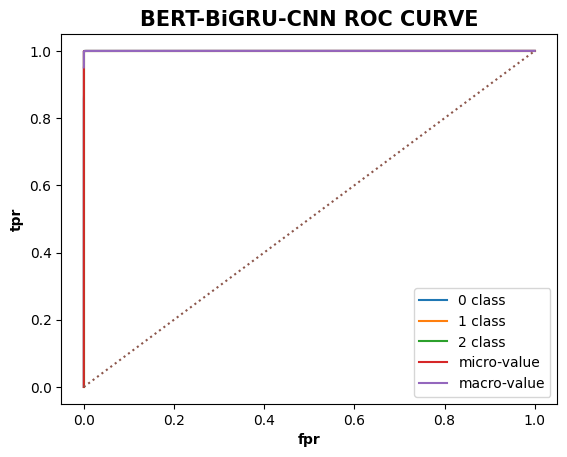

In [80]:
bigru_cnn_fpr,bigru_cnn_tpr,bigru_cnn_roc=network_roc_auc_onestep(df_test['class'],preds_bigru_cnn,num_classes=3,title='BERT-BiGRU-CNN ROC CURVE')

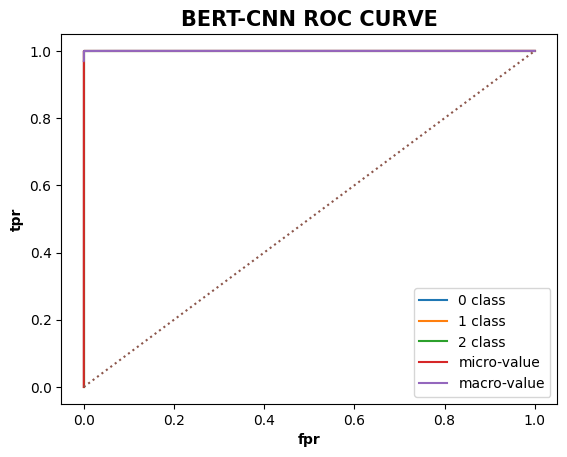

In [81]:

cnn_fpr,cnn_tpr,cnn_roc=network_roc_auc_onestep(df_test['class'],preds_cnn,num_classes=3,title='BERT-CNN ROC CURVE')


In [1]:
def network_confusion_matrix(y_test,y_pred,title):
    y_pred_index=np.argmax(y_pred,axis=1)
    cm_test=confusion_matrix(y_test,y_pred_index)
    cm_test=pd.DataFrame(cm_test,index=['irony','regular','sarcasm'],columns=['irony','regular','sarcasm'])
    plt.figure(figsize=(6,6),dpi=120)
    sns.heatmap(cm_test,annot=True,annot_kws={'size':8},cmap='PuBu',fmt='.1f')
    plt.yticks(rotation=90)
    plt.ylabel('True label',fontweight='bold')
    plt.xlabel('Predicted label',fontweight='bold')
    plt.title(title,fontweight='bold')
    plt.savefig(f'{title}.png')
    
    
    plt.show()

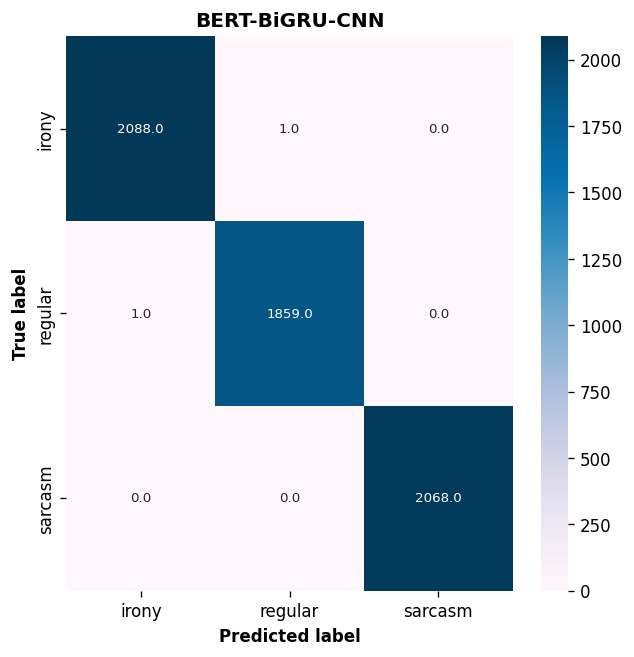

In [41]:
network_confusion_matrix(df_test['class'],preds_bigru_cnn,'BERT-BiGRU-CNN')

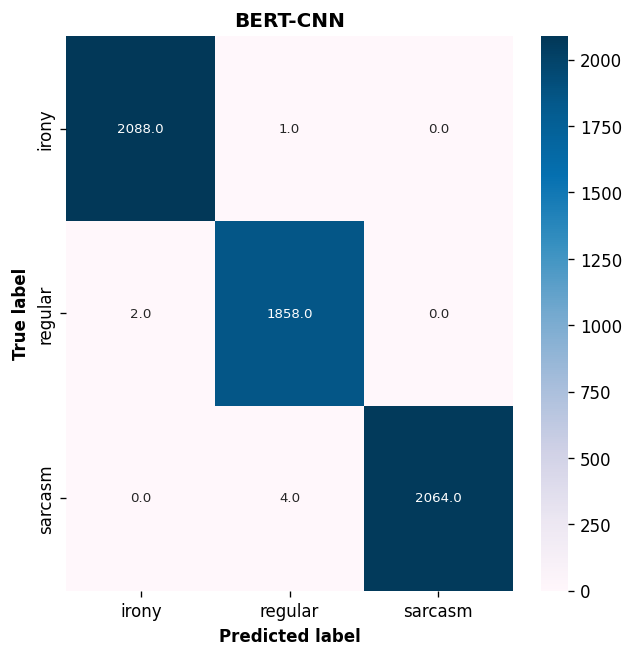

In [42]:
network_confusion_matrix(df_test['class'],preds_cnn,'BERT-CNN')

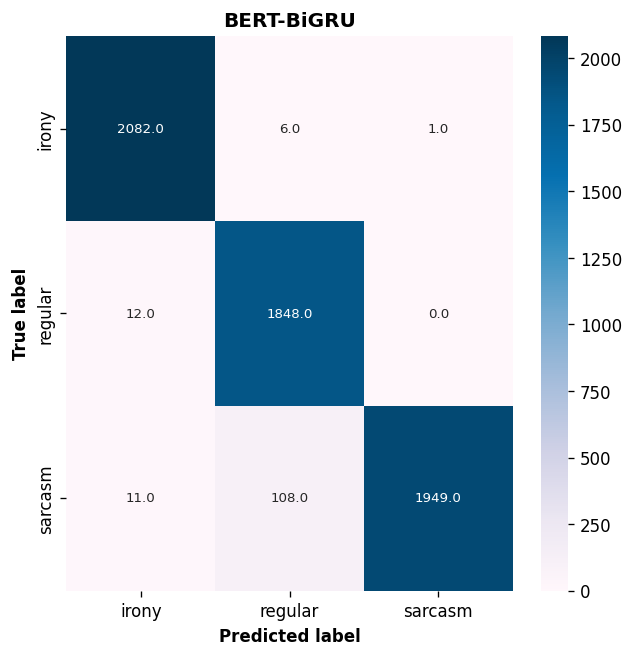

In [43]:
network_confusion_matrix(df_test['class'],preds_bigru,'BERT-BiGRU')

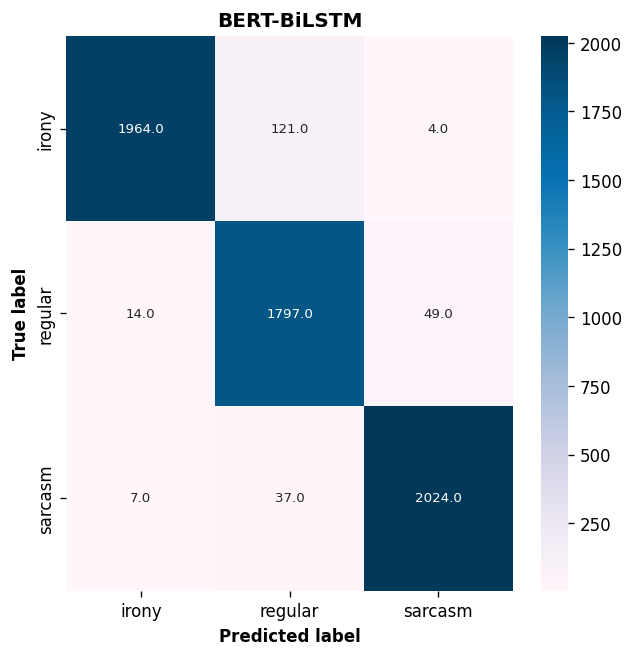

In [44]:
network_confusion_matrix(df_test['class'],preds_bilstm,'BERT-BiLSTM')

In [45]:
df_test

,tweets,class,clean_text,input_word_ids,attention_mask,token_type_ids
50715,"Woke up to a fight with my sisters. Yay, relat...",2.0,Woke fight sister Yay relationship sarcasm,"[101, 8271, 2954, 2905, 8038, 2100, 3276, 2095...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
37979,@SobtianHameshaa aur Jisko nahi karna wo ignor...,1.0,SobtianHameshaa aur Jisko nahi karna wo ignore...,"[101, 17540, 10772, 3511, 9953, 11057, 8740, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
12880,"Cracks me up when I hear Kim Kardashian say ""N...",0.0,Cracks I hear Kim Kardashian say North best ba...,"[101, 15288, 1045, 2963, 5035, 10556, 13639, 6...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
36517,"@DonnieWahlberg love ""your"" affirmations! Just...",1.0,DonnieWahlberg love affirmation Just didnt com...,"[101, 28486, 4213, 7317, 4059, 2293, 21358, 27...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
57089,"Despite the cost of living, have you noticed h...",2.0,Despite cost living noticed popular remains fu...,"[101, 2750, 3465, 2542, 4384, 2759, 3464, 6057...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...
22719,"Going bowling with @jacob2212 later today, goi...",1.0,Going bowling jacob later today going sleep bi...,"[101, 2183, 9116, 6213, 2101, 2651, 2183, 3637...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
16940,@RichardDawkins it was so to not offend anyone...,0.0,RichardDawkins offend anyone I guess irony,"[101, 2957, 2850, 26291, 7076, 2125, 10497, 30...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7679,@Cla_Cottingham so hoping someone was behind t...,0.0,ClaCottingham hoping someone behind taking pic...,"[101, 18856, 22684, 13027, 3511, 5327, 2619, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
12289,MyPOV: that was fun. first time i had to updat...,0.0,MyPOV fun first time update resume year nonpro...,"[101, 2026, 6873, 2615, 4569, 2034, 2051, 1065...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [42]:
df_news = pd.read_json(r"D:\华科学习\毕业设计\data\train.json", lines=True)[:10000]

In [43]:
df_news['new_text']=df_news['headline'].apply(lambda x:text_preprocessing(x))

In [44]:
encoded_inputs = tokenizer.batch_encode_plus(
    df_news['new_text'].tolist(), 
    padding=True, 
    truncation=True, 
    return_tensors='pt'
)


df_news['input_word_ids']=encoded_inputs['input_ids'].tolist()
df_news['attention_mask'] = encoded_inputs['attention_mask'].tolist()
df_news['token_type_ids'] = encoded_inputs['token_type_ids'].tolist()

In [46]:
class NewsDataset(Dataset):

    def __init__(self,df):
        super().__init__()
        self.df=df
        self.word_ids=np.array([word_ids for word_ids in df['input_word_ids']]).astype(int)
        self.attention_weights=np.array([attention for attention in df['attention_mask']]).astype(int)
        self.token_inputs=np.array([token for token in df['token_type_ids']]).astype(int)

        try:
            self.y=df['is_sarcastic'].values
        except:
            self.y=np.zeros(len(df))


    def __len__(self):
        return len(self.df)

    def __getitem__(self,i):
        return torch.tensor(self.word_ids[i],dtype=torch.long),torch.tensor(self.attention_weights[i],dtype=torch.long),torch.tensor(self.token_inputs[i],dtype=torch.long),torch.tensor(self.y[i],dtype=torch.long)






df_new_dataset=NewsDataset(df_news)

In [47]:
preds_bigru_cnn=[]
preds_cnn=[]
preds_bilstm=[]
preds_bigru=[]
labels=[]
test_correct=0
device=torch.device('cuda')
test_dataloader=DataLoader(df_new_dataset,batch_size=64,shuffle=False)


for input_id,token,attention,y in test_dataloader:
    input_id,token,attention=input_id.to(device),token.to(device),attention.to(device)

    y_preds=model(input_id,token,attention)
    predicted_classes = torch.argmax(y_preds, dim=1).cpu().numpy()

    # 映射成二分类：0,2 -> 1；1 -> 0
    binary_preds = [1 if p in [0, 2] else 0 for p in predicted_classes]
    preds_bigru_cnn.extend(binary_preds)

    labels.extend(y)

    test_correct += sum([p == t for p, t in zip(binary_preds, y)])

val_acc = test_correct / len(test_dataloader.dataset)
precision = precision_score(labels, preds_bigru_cnn, average='macro')
recall = recall_score(labels, preds_bigru_cnn, average='macro')
f1 = f1_score(labels, preds_bigru_cnn, average='macro')

print(f'ACC: {val_acc:.4f} - Precision: {precision:.4f} - Recall: {recall:.4f} - F1: {f1:.4f}')

test_correct=0
labels=[]

for input_id,token,attention,y in test_dataloader:
    input_id,token,attention=input_id.to(device),token.to(device),attention.to(device)

    y_preds=cnn(input_id,token,attention)
    predicted_classes = torch.argmax(y_preds, dim=1).cpu().numpy()

    # 映射成二分类：0,2 -> 1；1 -> 0
    binary_preds = [1 if p in [0, 2] else 0 for p in predicted_classes]
    preds_cnn.extend(binary_preds)

    labels.extend(y)

    test_correct += sum([p == t for p, t in zip(binary_preds, y)])

val_acc = test_correct / len(test_dataloader.dataset)
precision = precision_score(labels, preds_cnn, average='macro')
recall = recall_score(labels, preds_cnn, average='macro')
f1 = f1_score(labels, preds_cnn, average='macro')

print(f'ACC: {val_acc:.4f} - Precision: {precision:.4f} - Recall: {recall:.4f} - F1: {f1:.4f}')

test_correct=0
labels=[]

for input_id,token,attention,y in test_dataloader:
    input_id,token,attention=input_id.to(device),token.to(device),attention.to(device)

    y_preds=bilstm(input_id,token,attention)
    predicted_classes = torch.argmax(y_preds, dim=1).cpu().numpy()

    # 映射成二分类：0,2 -> 1；1 -> 0
    binary_preds = [1 if p in [0, 2] else 0 for p in predicted_classes]
    preds_bilstm.extend(binary_preds)

    labels.extend(y)

    test_correct += sum([p == t for p, t in zip(binary_preds, y)])

val_acc = test_correct / len(test_dataloader.dataset)
precision = precision_score(labels, preds_bilstm, average='macro')
recall = recall_score(labels, preds_bilstm, average='macro')
f1 = f1_score(labels, preds_bilstm, average='macro')

print(f'ACC: {val_acc:.4f} - Precision: {precision:.4f} - Recall: {recall:.4f} - F1: {f1:.4f}')


test_correct=0
labels=[]

for input_id,token,attention,y in test_dataloader:
    input_id,token,attention=input_id.to(device),token.to(device),attention.to(device)

    y_preds=bigru(input_id,token,attention)
    predicted_classes = torch.argmax(y_preds, dim=1).cpu().numpy()

    # 映射成二分类：0,2 -> 1；1 -> 0
    binary_preds = [1 if p in [0, 2] else 0 for p in predicted_classes]
    preds_bigru.extend(binary_preds)

    labels.extend(y)

    test_correct += sum([p == t for p, t in zip(binary_preds, y)])

val_acc = test_correct / len(test_dataloader.dataset)
precision = precision_score(labels, preds_bigru, average='macro')
recall = recall_score(labels, preds_bigru, average='macro')
f1 = f1_score(labels, preds_bigru, average='macro')

print(f'ACC: {val_acc:.4f} - Precision: {precision:.4f} - Recall: {recall:.4f} - F1: {f1:.4f}')


D:\Anaconda\Lib\site-packages\torch\nn\modules\conv.py:306: UserWarning:

Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)



ACC: 0.5172 - Precision: 0.4638 - Recall: 0.4991 - F1: 0.3455


D:\Anaconda\Lib\site-packages\torch\nn\modules\conv.py:306: UserWarning:

Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)



ACC: 0.5133 - Precision: 0.4920 - Recall: 0.4978 - F1: 0.3945
ACC: 0.5260 - Precision: 0.5225 - Recall: 0.5168 - F1: 0.4886
ACC: 0.5072 - Precision: 0.4905 - Recall: 0.4948 - F1: 0.4355


10000